## Implementation of CNN for Covid-19 CT Image Classification

import packages

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import models
from sklearn.metrics import accuracy_score, classification_report

# Data Preprocessing

In [6]:
# loading training dataset
train = pd.read_csv('/Users/siyuan/Desktop/ct project/S224/train.csv')
train.head()

,filename,label
0,NORMAL/Non-Covid (1014).png,0.0
1,NORMAL/Non-Covid (2).png,0.0
2,NORMAL/Non-Covid (311).png,0.0
3,NORMAL/Non-Covid (977).png,0.0
4,NORMAL/Non-Covid (664).png,0.0


In [3]:
# load all the train images and store them in an array format
train_img = []
for img_name in tqdm(train['filename']):
    # defining the image path
    image_path = '/Users/siyuan/Desktop/project/S224/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
train_x.shape

100%|██████████| 2022/2022 [00:29<00:00, 69.51it/s]


(2022, 224, 224, 3)

It is a Normal CT image


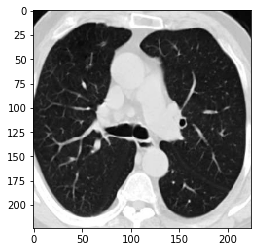

In [8]:
# Show the data
index = 100
plt.imshow(train_x[index][:,:,1],cmap='gray')
if (train['label'][index] == 0):
    print('It is a Normal CT image')
else:
    print('It is a COVID-19 CT image')

In [7]:
# defining the target
train_y = train['label'].values
# converting training & target images into torch format
train_x = train_x.reshape(-1, 3, 224, 224)
train_x  = torch.from_numpy(train_x)
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)
# shape of training data
train_x.shape, train_y.shape

(torch.Size([2022, 3, 224, 224]), torch.Size([2022]))

In [17]:
# load all test images and convert into torch format
test = pd.read_csv('/Users/siyuan/Desktop/project/S224/test.csv')
test_img = []
for img_name in tqdm(test['filename']):
    # defining the image path
    image_path = '/Users/siyuan/Desktop/project/S224/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)
# converting testing images into torch format
test_x = np.array(test_img)
test_show = test_x
test_y = test['label'].values
test_x = test_x.reshape(-1, 3, 224, 224)
test_x  = torch.from_numpy(test_x)
test_y = test_y.astype(int)
test_y = torch.from_numpy(test_y)
# shape of training data
print(test_x.shape, test_y.shape)

100%|██████████| 400/400 [00:06<00:00, 61.02it/s]


torch.Size([400, 3, 224, 224]) torch.Size([400])


In [9]:
# load all val images and convert into torch format
val = pd.read_csv('/Users/siyuan/Desktop/project/S224/val.csv')
val_img = []
for img_name in tqdm(val['filename']):
    # defining the image path
    image_path = '/Users/siyuan/Desktop/project/S224/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    val_img.append(img)

val_x = np.array(val_img)
val_y = val['label'].values
val_x = val_x.reshape(-1, 3, 224, 224)#rgb
val_x  = torch.from_numpy(val_x)
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)
# shape of training data
print(val_x.shape, val_y.shape)

100%|██████████| 60/60 [00:00<00:00, 60.95it/s]

torch.Size([60, 3, 224, 224]) torch.Size([60])


### 1) define a CNN based on Resnet-18 for binary classification

In [10]:
# define the structure for CNN scratched model
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=2):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,1),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(ResidualBlock)

In [11]:
# define hyper-parameter
EPOCH = 15
BATCH_SIZE = 128     
LR = 0.00001

# define to use GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define Resnet18 network
model = ResNet18()

#model = ResNet18().to(device)
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# defining the loss function
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Batch

In [ ]:
#show the weight map
#w1=model.conv1.weight.detach().cpu().numpy()
#print(w1.shape)
#fig, ax = plt.subplots(1,6, figsize=(8,8), constrained_layout=True)
#for i, axi in enumerate(ax.flat):
 #   axi.imshow(w1[i,0,:,:], cmap='gray')
 #   axi.axis('off')  

In [12]:
# define a function to save the model to a file
def save_checkpoint(filename, model, optimizer, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               filename)
    print('saved:', filename)
# define a function to load the model from a file    
def load_checkpoint(filename, model, optimizer):
    checkpoint=torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

### 2）train the CNN from scratch

In [11]:
training_loss_list = []
training_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
for epoch in range(1, EPOCH+1):

    # keep track of training loss
    permutation = torch.randperm(train_x.size()[0]) 
    TRAIN_loss = 0.0
    training_loss = []
    prediction = []
    target = []
    for i in tqdm(range(0,train_x.size()[0], BATCH_SIZE)): 

        indices = permutation[i:i+BATCH_SIZE] 
        batch_x, batch_y = train_x[indices], train_y[indices]
        
        #if torch.cuda.is_available():
        #    batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        # PyTorch accumulates the gradients on subsequent backward passes. 
        optimizer.zero_grad() 
        outputs = model(batch_x)
        
        loss = criterion(outputs,batch_y)
        training_loss.append(loss.item())
        
        softmax = torch.exp(outputs).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1) #index of largest element
        prediction.append(predictions)
        target.append(batch_y)
        
        loss.backward()
        optimizer.step()
        
    TRAIN_loss = np.average(training_loss)
    training_loss_list.append(TRAIN_loss)
    # training accuracy
    accuracy = []
    for i in range(len(prediction)):
        accuracy.append(accuracy_score(target[i],prediction[i]))
    training_accuracy_list.append(np.average(accuracy))
    
    # keep track of validation loss
    prediction_val = []
    target_val = []
    val_loss = []
    VAL_loss = 0.0
    permutation = torch.randperm(val_x.size()[0])
    for i in range(0,val_x.size()[0], BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x, batch_y = val_x[indices], val_y[indices]

        #if torch.cuda.is_available():
        #  batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        with torch.no_grad():
            output = model(batch_x)

        loss = criterion(output,batch_y)
        val_loss.append(loss.item())
        
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        prediction_val.append(predictions)
        target_val.append(batch_y)
    
    # validation loss & accuracy
    VAL_loss = np.average(val_loss)
    val_loss_list.append(VAL_loss)
    
    accuracy_val = []
    #append predictions and accuracies for each iteration
    for i in range(len(prediction_val)):
        accuracy_val.append(accuracy_score(target_val[i],prediction_val[i]))
    val_accuracy_list.append(np.average(accuracy_val))
    #save the model for each epoch
    filename='Baseline_Pytorch_e'+str(epoch)+'.pt'
    save_checkpoint(filename, model, optimizer, epoch)
    print('epoch: \t', epoch, '\t training loss: \t', TRAIN_loss, '\t training acc: \t', np.average(accuracy), '\t val loss: \t', VAL_loss, 'val acc: \t', np.average(accuracy_val))

    

100%|██████████| 16/16 [01:14<00:00,  4.63s/it]


saved: Baseline_Pytorch_e1.pt
epoch: 	 1 	 training loss: 	 0.6581535004079342 	 training acc: 	 0.6151482077205882 	 val loss: 	 0.6404565572738647 val acc: 	 0.6


100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


saved: Baseline_Pytorch_e2.pt
epoch: 	 2 	 training loss: 	 0.4979295860975981 	 training acc: 	 0.7589901194852942 	 val loss: 	 0.5926848649978638 val acc: 	 0.6666666666666666


100%|██████████| 16/16 [01:08<00:00,  4.28s/it]


saved: Baseline_Pytorch_e3.pt
epoch: 	 3 	 training loss: 	 0.39578864350914955 	 training acc: 	 0.8405330882352942 	 val loss: 	 0.5244506001472473 val acc: 	 0.7666666666666667


100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


saved: Baseline_Pytorch_e4.pt
epoch: 	 4 	 training loss: 	 0.27269222121685743 	 training acc: 	 0.9092850030637255 	 val loss: 	 0.45369499921798706 val acc: 	 0.7833333333333333


100%|██████████| 16/16 [01:09<00:00,  4.32s/it]


saved: Baseline_Pytorch_e5.pt
epoch: 	 5 	 training loss: 	 0.166780564468354 	 training acc: 	 0.9543313419117647 	 val loss: 	 0.35803890228271484 val acc: 	 0.7666666666666667


100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


saved: Baseline_Pytorch_e6.pt
epoch: 	 6 	 training loss: 	 0.09209009120240808 	 training acc: 	 0.98046875 	 val loss: 	 0.32773035764694214 val acc: 	 0.85


100%|██████████| 16/16 [01:08<00:00,  4.27s/it]


saved: Baseline_Pytorch_e7.pt
epoch: 	 7 	 training loss: 	 0.051167772500775754 	 training acc: 	 0.9931640625 	 val loss: 	 0.2954556345939636 val acc: 	 0.85


100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


saved: Baseline_Pytorch_e8.pt
epoch: 	 8 	 training loss: 	 0.030409167404286563 	 training acc: 	 0.99853515625 	 val loss: 	 0.2607472538948059 val acc: 	 0.85


100%|██████████| 16/16 [01:09<00:00,  4.34s/it]


saved: Baseline_Pytorch_e9.pt
epoch: 	 9 	 training loss: 	 0.016920682683121413 	 training acc: 	 0.99951171875 	 val loss: 	 0.2901977300643921 val acc: 	 0.8833333333333333


100%|██████████| 16/16 [01:09<00:00,  4.33s/it]


saved: Baseline_Pytorch_e10.pt
epoch: 	 10 	 training loss: 	 0.011887682863743976 	 training acc: 	 1.0 	 val loss: 	 0.2876856029033661 val acc: 	 0.8833333333333333


100%|██████████| 16/16 [01:10<00:00,  4.41s/it]


saved: Baseline_Pytorch_e11.pt
epoch: 	 11 	 training loss: 	 0.009471883968217298 	 training acc: 	 1.0 	 val loss: 	 0.2517487406730652 val acc: 	 0.8833333333333333


100%|██████████| 16/16 [01:09<00:00,  4.37s/it]


saved: Baseline_Pytorch_e12.pt
epoch: 	 12 	 training loss: 	 0.005942728166701272 	 training acc: 	 1.0 	 val loss: 	 0.2709976136684418 val acc: 	 0.8833333333333333


100%|██████████| 16/16 [01:10<00:00,  4.40s/it]


saved: Baseline_Pytorch_e13.pt
epoch: 	 13 	 training loss: 	 0.005634715547785163 	 training acc: 	 1.0 	 val loss: 	 0.2681274712085724 val acc: 	 0.8666666666666667


100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


saved: Baseline_Pytorch_e14.pt
epoch: 	 14 	 training loss: 	 0.005279119737679139 	 training acc: 	 1.0 	 val loss: 	 0.27550727128982544 val acc: 	 0.8833333333333333


100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


saved: Baseline_Pytorch_e15.pt
epoch: 	 15 	 training loss: 	 0.004868410935159773 	 training acc: 	 1.0 	 val loss: 	 0.26846733689308167 val acc: 	 0.8833333333333333


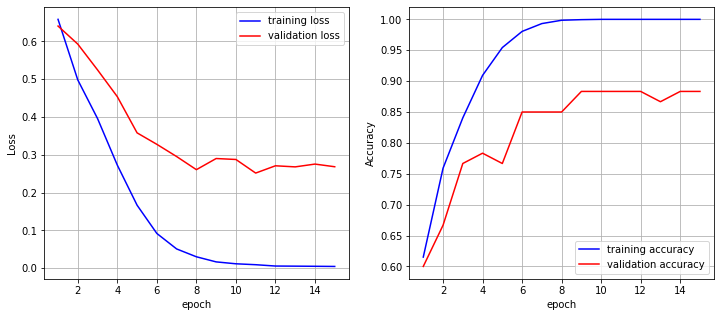

In [12]:
# draw the curves of loss vs epoch
epochs = range(1,EPOCH+1)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, training_loss_list, 'b', label='training loss')
plt.plot(epochs, val_loss_list, 'r', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, training_accuracy_list, 'b', label='training accuracy')
plt.plot(epochs, val_accuracy_list, 'r', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# load the best model
model = ResNet18()
filename_best='Baseline_Pytorch_e15.pt'
load_checkpoint(filename_best, model, optimizer)

In [43]:
# prediction for test set
prediction_test = []
target_test = []
permutation = torch.randperm(test_x.size()[0])
for i in range(0,test_x.size()[0],BATCH_SIZE):
    indices = permutation[i:i+BATCH_SIZE]
    batch_x, batch_y = test_x[indices], test_y[indices]

    #if torch.cuda.is_available():
     #   batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_test.append(predictions)
    target_test.append(batch_y)
    
# validation accuracy
accuracy_test = []
for i in range(len(prediction_test)):
    accuracy_test.append(accuracy_score(target_test[i],prediction_test[i]))
    
print('test accuracy: \t', np.average(accuracy_test))

# print precision, recall & F1 score
target_names = ['class 0: Non-Covid', 'class 1: Covid']
target = np.array(list(np.concatenate(target_test).flat))
prediction = np.array(list(np.concatenate(prediction_test).flat))
print("classification reports：")
print(classification_report(target, prediction, target_names=target_names))

test accuracy: 	 0.88671875
classification reports：
                    precision    recall  f1-score   support

class 0: Non-Covid       0.91      0.91      0.91       200
    class 1: Covid       0.91      0.91      0.91       200

          accuracy                           0.91       400
         macro avg       0.91      0.91      0.91       400
      weighted avg       0.91      0.91      0.91       400



### 3) train the CNN using transfer learning

In [14]:
# loading the pretrained model
transfer_model = models.resnet18(pretrained=True)
# Freeze all model weights
for param in transfer_model.parameters():
    param.requires_grad = False
# set the parameters of fc to be trainable
for param in transfer_model.fc.parameters():
    param.requires_grad=True
# Modify the dimension of the last layer with output dimension 2
dim = transfer_model.fc.in_features
transfer_model.fc = nn.Linear(dim, 2)

EPOCH = 15
# defining the optimizer
optimizer = optim.SGD(transfer_model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
    
# checking if GPU is available
#if torch.cuda.is_available():
#    transfer_model = transfer_model.cuda()

In [31]:
#initialization of array for loss and accuracy 
training_loss_list = []
training_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
for epoch in range(1, EPOCH+1):

    # keep track of training and validation loss
    permutation = torch.randperm(train_x.size()[0])
    TRAIN_loss = 0.0
    training_loss = []
    prediction = []
    target = []
    for i in tqdm(range(0,train_x.size()[0], BATCH_SIZE)):

        indices = permutation[i:i+BATCH_SIZE]
        batch_x, batch_y = train_x[indices], train_y[indices]
        
        #if torch.cuda.is_available():
        #    batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = transfer_model(batch_x)
        
        loss = criterion(outputs,batch_y)
        training_loss.append(loss.item())
        
        softmax = torch.exp(outputs).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1)
        prediction.append(predictions)
        target.append(batch_y)
        
        loss.backward()
        optimizer.step()
        
    TRAIN_loss = np.average(training_loss)
    training_loss_list.append(TRAIN_loss)
    # training accuracy
    accuracy = []
    for i in range(len(prediction)):
        accuracy.append(accuracy_score(target[i],prediction[i]))
    training_accuracy_list.append(np.average(accuracy))
    
    # prediction for validation set
    prediction_val = []
    target_val = []
    val_loss = []
    VAL_loss = 0.0
    permutation = torch.randperm(val_x.size()[0])
    for i in range(0,val_x.size()[0], BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x, batch_y = val_x[indices], val_y[indices]

        #if torch.cuda.is_available():
        #  batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        with torch.no_grad():
            output = transfer_model(batch_x)

        loss = criterion(output,batch_y)
        val_loss.append(loss.item())
        
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        prediction_val.append(predictions)
        target_val.append(batch_y)
    
    # validation loss & accuracy
    VAL_loss = np.average(val_loss)
    val_loss_list.append(VAL_loss)
    
    accuracy_val = []
    for i in range(len(prediction_val)):
        accuracy_val.append(accuracy_score(target_val[i],prediction_val[i]))
    val_accuracy_list.append(np.average(accuracy_val))
    filename='Transfer_learning_Pytorch_e'+str(epoch)+'.pt'
    save_checkpoint(filename, transfer_model, optimizer, epoch)
    
    print('epoch: \t', epoch, '\t training loss: \t', TRAIN_loss, '\t training acc: \t', np.average(accuracy), '\t val loss: \t', VAL_loss, 'val acc: \t', np.average(accuracy_val))

    

100%|██████████| 16/16 [01:07<00:00,  4.24s/it]


saved: Transfer_learning_Pytorch_e1.pt
epoch: 	 1 	 training loss: 	 0.6187568716704845 	 training acc: 	 0.6601945465686274 	 val loss: 	 0.595172107219696 val acc: 	 0.6


100%|██████████| 16/16 [01:07<00:00,  4.25s/it]


saved: Transfer_learning_Pytorch_e2.pt
epoch: 	 2 	 training loss: 	 0.46231930889189243 	 training acc: 	 0.7834041819852942 	 val loss: 	 0.5328693985939026 val acc: 	 0.7166666666666667


100%|██████████| 16/16 [01:08<00:00,  4.26s/it]


saved: Transfer_learning_Pytorch_e3.pt
epoch: 	 3 	 training loss: 	 0.34884754568338394 	 training acc: 	 0.8672832414215687 	 val loss: 	 0.47446033358573914 val acc: 	 0.7833333333333333


100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


saved: Transfer_learning_Pytorch_e4.pt
epoch: 	 4 	 training loss: 	 0.2695074137300253 	 training acc: 	 0.9064797794117647 	 val loss: 	 0.4719814658164978 val acc: 	 0.7833333333333333


100%|██████████| 16/16 [01:07<00:00,  4.21s/it]


saved: Transfer_learning_Pytorch_e5.pt
epoch: 	 5 	 training loss: 	 0.20606162305921316 	 training acc: 	 0.9440870098039216 	 val loss: 	 0.39722299575805664 val acc: 	 0.8166666666666667


100%|██████████| 16/16 [01:05<00:00,  4.07s/it]


saved: Transfer_learning_Pytorch_e6.pt
epoch: 	 6 	 training loss: 	 0.1517079290933907 	 training acc: 	 0.9661841299019608 	 val loss: 	 0.3813186287879944 val acc: 	 0.8333333333333334


100%|██████████| 16/16 [01:08<00:00,  4.28s/it]


saved: Transfer_learning_Pytorch_e7.pt
epoch: 	 7 	 training loss: 	 0.10912138316780329 	 training acc: 	 0.9824123008578431 	 val loss: 	 0.41633346676826477 val acc: 	 0.85


100%|██████████| 16/16 [01:08<00:00,  4.25s/it]


saved: Transfer_learning_Pytorch_e8.pt
epoch: 	 8 	 training loss: 	 0.07869610586203635 	 training acc: 	 0.9913258272058824 	 val loss: 	 0.3558730483055115 val acc: 	 0.8166666666666667


100%|██████████| 16/16 [01:05<00:00,  4.12s/it]


saved: Transfer_learning_Pytorch_e9.pt
epoch: 	 9 	 training loss: 	 0.06441457779146731 	 training acc: 	 0.9970703125 	 val loss: 	 0.3656326234340668 val acc: 	 0.85


100%|██████████| 16/16 [01:05<00:00,  4.10s/it]


saved: Transfer_learning_Pytorch_e10.pt
epoch: 	 10 	 training loss: 	 0.047227084753103554 	 training acc: 	 0.99560546875 	 val loss: 	 0.3720473349094391 val acc: 	 0.8333333333333334


100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


saved: Transfer_learning_Pytorch_e11.pt
epoch: 	 11 	 training loss: 	 0.037794248666614294 	 training acc: 	 0.9970703125 	 val loss: 	 0.35949352383613586 val acc: 	 0.8333333333333334


100%|██████████| 16/16 [01:08<00:00,  4.25s/it]


saved: Transfer_learning_Pytorch_e12.pt
epoch: 	 12 	 training loss: 	 0.029280514921993017 	 training acc: 	 0.99951171875 	 val loss: 	 0.3804479241371155 val acc: 	 0.85


100%|██████████| 16/16 [01:07<00:00,  4.22s/it]


saved: Transfer_learning_Pytorch_e13.pt
epoch: 	 13 	 training loss: 	 0.022230308793950826 	 training acc: 	 1.0 	 val loss: 	 0.3788432776927948 val acc: 	 0.8333333333333334


100%|██████████| 16/16 [01:06<00:00,  4.17s/it]


saved: Transfer_learning_Pytorch_e14.pt
epoch: 	 14 	 training loss: 	 0.019812208076473325 	 training acc: 	 1.0 	 val loss: 	 0.3629717528820038 val acc: 	 0.8333333333333334


100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


saved: Transfer_learning_Pytorch_e15.pt
epoch: 	 15 	 training loss: 	 0.015066600986756384 	 training acc: 	 1.0 	 val loss: 	 0.3736685812473297 val acc: 	 0.8333333333333334


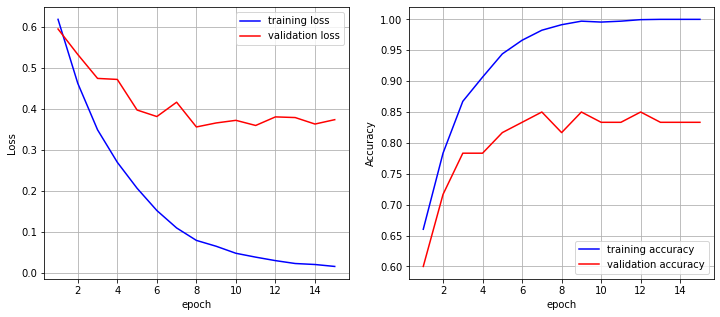

In [33]:
# draw the curves of loss vs epoch
epochs = range(1,EPOCH+1)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, training_loss_list, 'b', label='training loss')
plt.plot(epochs, val_loss_list, 'r', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, training_accuracy_list, 'b', label='training accuracy')
plt.plot(epochs, val_accuracy_list, 'r', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# load the best model
filename_best='Transfer_learning_Pytorch_e15.pt'
load_checkpoint(filename_best, transfer_model, optimizer)

# prediction for test set
prediction_test = []
target_test = []
permutation = torch.randperm(test_x.size()[0])
for i in range(0,test_x.size()[0],BATCH_SIZE):
    indices = permutation[i:i+BATCH_SIZE]
    batch_x, batch_y = test_x[indices], test_y[indices]

    #if torch.cuda.is_available():
     #   batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = transfer_model(batch_x)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_test.append(predictions)
    target_test.append(batch_y)
    
# validation accuracy
accuracy_test = []
for i in range(len(prediction_test)):
    accuracy_test.append(accuracy_score(target_test[i],prediction_test[i]))
    
print('test accuracy: \t', np.average(accuracy_test))

# print precision, recall & F1 score
target_names = ['class 0: Non-Covid', 'class 1: Covid']
target = np.array(list(np.concatenate(target_test).flat))
prediction = np.array(list(np.concatenate(prediction_test).flat))
print("classification reports：")
print(classification_report(target, prediction, target_names=target_names))

test accuracy: 	 0.8828125
classification reports：
                    precision    recall  f1-score   support

class 0: Non-Covid       0.89      0.92      0.90       200
    class 1: Covid       0.92      0.89      0.90       200

          accuracy                           0.90       400
         macro avg       0.90      0.90      0.90       400
      weighted avg       0.90      0.90      0.90       400



baseline(learning from scrach): 88.67% 

transfer learning(with pretrained ResNet18): 88.28%

It is a Normal CT image


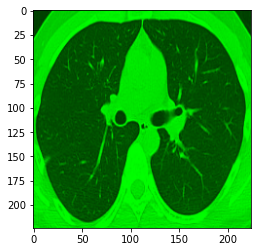

Predicted:
It is a Normal CT image


In [40]:
index = 89
plt.imshow(test_show[index])
if (test['label'][index] == 0):
    print('It is a Normal CT image')
else:
    print('It is a COVID-19 CT image')
output = transfer_model(test_x[index].unsqueeze(0))
softmax = torch.exp(output).cpu()
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob)
plt.show()
print('Predicted:')
if (predictions == 0):
    print('It is a Normal CT image')
else:
    print('It is a COVID-19 CT image')

It is a COVID-19 CT image


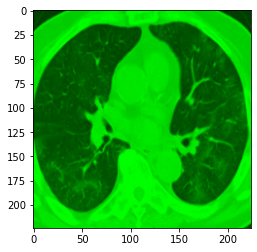

Predicted:
It is a COVID-19 CT image


In [41]:
index = 202
plt.imshow(test_show[index])
if (test['label'][index] == 0):
    print('It is a Normal CT image')
else:
    print('It is a COVID-19 CT image')
output = transfer_model(test_x[index].unsqueeze(0))
softmax = torch.exp(output).cpu()
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob)
plt.show()
print('Predicted:')
if (predictions == 0):
    print('It is a Normal CT image')
else:
    print('It is a COVID-19 CT image')

# Conclusion